# Vector Project - Centralized Unsupervised Classifier

## Installs and Import

In [5]:
#pip install tabulate

Looking in indexes: https://artifactory.fg.rbc.com/artifactory/api/pypi/pypi-remote/simple, https://artifactory.fg.rbc.com/artifactory/api/pypi/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
#pip install sickit-learn

Looking in indexes: https://artifactory.fg.rbc.com/artifactory/api/pypi/pypi-remote/simple, https://artifactory.fg.rbc.com/artifactory/api/pypi/pypi/simple
ERROR: Could not find a version that satisfies the requirement sickit-learn (from versions: none)
ERROR: No matching distribution found for sickit-learn
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Data Exploration

In [2]:
#Import Data
df_v3 = pd.read_excel("/projects/federated_learning/RBC1/RBC_Synthetic_Data/20250314_synthetic_flight_data_v3_50000.xlsx")
df_v4 = pd.read_excel("/projects/federated_learning/RBC1/RBC_Synthetic_Data/20250314_synthetic_flight_data_v4_50000.xlsx")
df_v5 = pd.read_excel("/projects/federated_learning/RBC1/RBC_Synthetic_Data/20250314_synthetic_flight_data_v5_50000.xlsx")

In [3]:
# Combine the three DataFrames into one
combined_df = pd.concat([df_v3, df_v4, df_v5], ignore_index=True)
# 1. Data Exploration
print("Data Exploration:\n")
print("Shape of the combined DataFrame:", combined_df.shape)
print("\nData types of each column:\n", combined_df.dtypes)
print("\nDescriptive statistics of the combined DataFrame:\n", combined_df.describe().to_markdown(numalign="left", stralign="left"))

Data Exploration:

Shape of the combined DataFrame: (101000, 24)

Data types of each column:
 Date                     datetime64[ns]
sales_channel                    object
trip_type                        object
purchase_lead                     int64
length_of_stay                    int64
flight_hour                       int64
flight_day                       object
origin                           object
destination                      object
wants_extra_baggage               int64
wants_preferred_seat              int64
wants_in_flight_meals             int64
flight_duration                 float64
booking_complete                  int64
airline_carrier                  object
age                               int64
gender                           object
credit_score                      int64
income                            int64
social_group                     object
life_stage                       object
ticket_type                      object
client_segment            

In [4]:
#Fix boolean columns back to int
bool_cols = [col for col in combined_df.columns if combined_df[col].dtype == 'bool']

for i in range(len(bool_cols)):
    combined_df[bool_cols[i]] = combined_df[bool_cols[i]].astype(int)


## Feature Engineering

In [5]:
# Feature Engineering
print("\nFeature Engineering:\n")

# Convert flight_cost to numeric categories 1-4
def convert_flight_cost(cost_str):
    if cost_str == '$':
        return 1
    elif cost_str == '$$':
        return 2
    elif cost_str == '$$$':
        return 3
    elif cost_str == '$$$$':
        return 4
    else:
        return None  # Handle potential errors or unknown values

combined_df['flight_cost_num'] = combined_df['flight_cost'].apply(convert_flight_cost)
combined_df['flight_cost_num'] = combined_df['flight_cost_num'].fillna(combined_df['flight_cost_num'].mode()[0])

# Create dummy variables for flight_cost_num - not needed for ordinal data
#combined_df = pd.get_dummies(combined_df, columns=['flight_cost_num'], prefix='flight_cost', drop_first=True)

# Date to Day of Year (Cyclical Representation)
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
days_in_year = combined_df['Date'].dt.isocalendar().day.max()

#Date to week of year
combined_df['week_num'] = combined_df['Date'].dt.isocalendar().week

#combined_df['Day_of_Year_sin'] = np.sin(2 * np.pi * combined_df['Date'].dt.isocalendar().day / days_in_year) #date sin
#combined_df['Day_of_Year_cos'] = np.cos(2 * np.pi * combined_df['Date'].dt.isocalendar().day / days_in_year) #date cos

# Flight Day to Weekday/Weekend
combined_df['Day_Type'] = combined_df['flight_day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Origin/Destination to Hub/Not Hub (Example hub list - this can be expanded)
#major_hubs = ['London', 'Chicago', 'Los Angeles', 'New York', 'San Francisco', 'Toronto']

#def is_hub(city):
#    return 'Hub' if city in major_hubs else 'Not_Hub'
#
#combined_df['Origin_Hub'] = combined_df['origin'].apply(is_hub)
#combined_df['Destination_Hub'] = combined_df['destination'].apply(is_hub)

# Airline Carrier to Premium/Discount (Example mapping - this can be expanded)
#airline_mapping = {
#    'United Airlines': 'Premium',
#    'Westjet': 'Discount',
#    'Air India': 'Discount',
#    'Emirates': 'Premium',
#    'British Airways': 'Premium',
#    'Lufthansa': 'Premium',
#    'Southwest': 'Discount'
#}

#combined_df['Airline_Type'] = combined_df['airline_carrier'].map(airline_mapping).fillna('Other')  # Handle airlines not in the mapping

# Drop original columns
#combined_df = combined_df.drop(columns=['Date', 'flight_day', 'origin', 'destination', 'airline_carrier', 'flight_cost'])
combined_df = combined_df.drop(columns=['Date', 'flight_day','flight_cost']) #revised

# Identify categorical columns for one-hot encoding (after transformations)
categorical_cols = [col for col in combined_df.columns if combined_df[col].dtype == 'object']

# Perform one-hot encoding
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# Display the shape of the transformed DataFrame
print("\nShape of the transformed DataFrame:", combined_df.shape)


Feature Engineering:


Shape of the transformed DataFrame: (101000, 51)


In [6]:
#Bool to int
bool_cols = [col for col in combined_df.columns if combined_df[col].dtype == 'bool']

for i in range(len(bool_cols)):
    combined_df[bool_cols[i]] = combined_df[bool_cols[i]].astype(int)

In [7]:
# Display the first 5 rows of the transformed DataFrame
combined_df.head()

,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,age,credit_score,...,airline_carrier_Westjet,gender_Male,social_group_Urban,life_stage_Parent,life_stage_Retired,life_stage_Single,life_stage_Young Professional,ticket_type_economy,client_segment_premium,Day_Type_Weekend
0,247,3,11,1,0,1,11.1,0,51,608,...,0,1,0,0,1,0,0,1,1,0
1,108,11,13,1,0,1,19.0,1,26,607,...,0,0,0,0,0,1,0,1,1,0
2,181,4,18,0,1,0,1.6,0,28,770,...,0,1,1,0,0,0,0,1,1,0
3,314,2,10,0,0,1,11.3,0,29,867,...,0,1,0,0,1,0,0,1,0,0
4,9,1,2,0,1,1,2.6,0,27,826,...,1,0,1,0,1,0,0,1,0,0


## PCA

In [8]:
# 4. PCA for Feature Selection
print("\nPCA for Feature Selection:\n")

# Separate features (X) from the target variable (if any)
X = combined_df  # Assuming all columns are features

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Get feature names
feature_names = X.columns

# Create a DataFrame to hold explained variance ratios
explained_variance_df = pd.DataFrame({'Component': range(1, len(explained_variance) + 1),
                                      'Explained Variance': explained_variance})

# Assign feature names to components
explained_variance_df['Feature'] = feature_names[:len(explained_variance_df)]

print("\nExplained variance ratio with feature names:\n")
print(explained_variance_df.head(20).to_markdown(index=False, numalign="left", stralign="left"))

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)
print("\nCumulative explained variance:\n", cumulative_explained_variance)

# Determine the number of components that explain 95% of the variance
n_components_85 = np.argmax(cumulative_explained_variance >= 0.85) + 1
print(f"\nNumber of components explaining 85% of variance: {n_components_85}")


PCA for Feature Selection:


Explained variance ratio with feature names:

| Component   | Explained Variance   | Feature               |
|:------------|:---------------------|:----------------------|
| 1           | 0.0384688            | purchase_lead         |
| 2           | 0.0294302            | length_of_stay        |
| 3           | 0.0246021            | flight_hour           |
| 4           | 0.0245786            | wants_extra_baggage   |
| 5           | 0.0245673            | wants_preferred_seat  |
| 6           | 0.0241314            | wants_in_flight_meals |
| 7           | 0.0231093            | flight_duration       |
| 8           | 0.022991             | booking_complete      |
| 9           | 0.0229488            | age                   |
| 10          | 0.0229164            | credit_score          |
| 11          | 0.0228958            | income                |
| 12          | 0.0228688            | flight_cost_num       |
| 13          | 0.0223103            | wee

## Pre-Processing

In [9]:
#Filter to features accounting for 85% of columative variance
relevant_col_list = explained_variance_df['Feature'].values.tolist()[:n_components_85]
pca_filtered_df = combined_df.filter(items =  relevant_col_list)

In [10]:
#Normalize values to be between 0 and 1
columns_to_scale = [col for col in pca_filtered_df.columns if pca_filtered_df[col].max() > 1]
pca_filtered_df[columns_to_scale] = minmax_scale(pca_filtered_df[columns_to_scale])

## Autoencoder (No longer needed)

In [9]:
# Define the Autoencoder
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(Autoencoder, self).__init__()
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 64), nn.ReLU(),
#             nn.Linear(64, 32), nn.ReLU(),
#             nn.Linear(32, latent_dim)  # Compressed Representation
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 32), nn.ReLU(),
#             nn.Linear(32, 64), nn.ReLU(),
#             nn.Linear(64, input_dim)  # Output should match input_dim
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded, encoded

# # Define dimensions
# input_dim = pca_filtered_df.shape[1]  # Should match PCA components
# latent_dim = 5  # Choose small enough for clustering
# model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)


# # Convert PCA-transformed data to tensor
# X_tensor = torch.FloatTensor(pca_filtered_df.values)

# # Define optimizer and loss function
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# epochs = 100
# for epoch in range(epochs):
#     optimizer.zero_grad()
#     reconstructed, latent_features = model(X_tensor)
#     loss = criterion(reconstructed, X_tensor)  # Reconstruction Loss
#     loss.backward()
#     optimizer.step()
    
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")


Epoch 0/100, Loss: 0.2338
Epoch 10/100, Loss: 0.2003
Epoch 20/100, Loss: 0.1667
Epoch 30/100, Loss: 0.1258
Epoch 40/100, Loss: 0.1161
Epoch 50/100, Loss: 0.1150
Epoch 60/100, Loss: 0.1140
Epoch 70/100, Loss: 0.1134
Epoch 80/100, Loss: 0.1130
Epoch 90/100, Loss: 0.1126


In [10]:
# Extract decoded uputput as K-means input
# X = reconstructed.detach().numpy()

## K-Means Clustering

In [11]:
#Create varable for K-Means
X = pca_filtered_df

### Shiloutte Score

In [20]:
#Evaluate how many clusters - shiloutte score

# candidate values for our number of cluster
parameters = list(range(2,11))

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X)          # fit model on data, this will find clusters based on parameter p
    ss = silhouette_score(X, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
        
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

KeyboardInterrupt: 

### Elbow Method

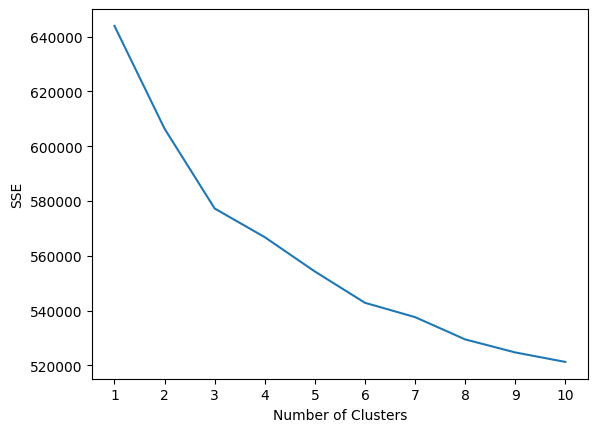

In [22]:
#Evaluate How many clusters - Elbow method

#Initialize Parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [38]:
# Apply K-Means to Optimal number of clusters

# Fit
km = KMeans(n_clusters=3)
km.fit(X)

#Add Columns to df with labels
X['Cluster'] = km.labels_

#Rename
df = X

## Label Distriburion

In [24]:
label_test = df.groupby('Cluster', sort = False).count()
label_test

,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,age,credit_score,...,destination_Minneapolis,destination_New York,destination_Paris,destination_San Francisco,destination_Tokyo,airline_carrier_American Airlines,airline_carrier_British Airways,airline_carrier_Delta Air Lines,airline_carrier_Emirates,airline_carrier_Lufthansa
Cluster,,,,,,,,,,,,,,,,,,,,,
0,33740,33740,33740,33740,33740,33740,33740,33740,33740,33740,...,33740,33740,33740,33740,33740,33740,33740,33740,33740,33740
1,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538,...,33538,33538,33538,33538,33538,33538,33538,33538,33538,33538
2,33722,33722,33722,33722,33722,33722,33722,33722,33722,33722,...,33722,33722,33722,33722,33722,33722,33722,33722,33722,33722


## Nueral Network

### Define Dataset and Dataloaders

In [14]:
class TabularDataset(Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor = None) -> None:
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int):
        if self.y is None:
            # For test dataset
            return self.x[idx], None
        else:
            # For train and validation dataset
            return self.x[idx], self.y[idx]

### Define Model and Optimizers

In [15]:
#Define Model
class TitanicModel(nn.Module):
    def __init__(self, input_dim: int, num_classes: int = 3) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 96)
        self.linear4 = nn.Linear(96, 32)
        self.linear5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.dropout(self.relu(self.linear3(x)))
        x = self.dropout(self.relu(self.linear4(x)))
        output = self.softmax(self.linear5(x))
        return output

In [16]:
# Assign the available processor to device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Client Specific DataSet

In [39]:
#Filter to only client 1 Data (Reset here and run model for each data set for quick testing)
index_list_1 = list(range(len(df_v3)))
index_list_2 = list(range(max(index_list_1)+1,max(index_list_1)+50001))
index_list_3 = list(range(max(index_list_2)+1,max(index_list_2)+50001))

df1 = df[df.index.isin(index_list_3)].copy()
# Separate training features from label column
train_labels = df1["Cluster"].copy()
df = df1.drop("Cluster", axis=1).copy()

In [40]:
#Create train, test, valid split (60,20,20)
x_data = torch.tensor(df.values, dtype=torch.float32)
y_data = torch.tensor(train_labels.values, dtype=torch.float32)


x, x_test, y, y_test = train_test_split(x_data,y_data,test_size=0.2,train_size=0.8, shuffle = True)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.25,train_size =0.75, shuffle = True)

#x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25, shuffle=True)

In [41]:
# Create dataset
train_dataset = TabularDataset(x_train, y_train)
validation_dataset = TabularDataset(x_valid, y_valid)
test_dataset = TabularDataset(x_test, None)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

### Train Model

In [42]:
#Define Model
model = TitanicModel(n_components_85).to(device)

In [43]:
#Define Loss function and optimizer

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.003)


def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [44]:
# Number of epochs
epochs = 200


# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    total_train_loss: float = 0
    total_train_acc: float = 0
    num_train_batches: float = 0

    for x_train, y_train in train_loader:

        # Send data to the device
        x_train = x_train.to(device)
        y_train = y_train.type(torch.LongTensor).to(device)

        # Forward pass to get predictions
        y_logits = model(x_train)
        # Convert logits into predictions
        y_pred = torch.argmax(y_logits, dim=1)

        # Compute the loss
        loss = loss_fn(y_logits, y_train)
        # Calculate the accuracy; convert the labels to integers
        acc = accuracy_fn(y_train, y_pred)

        # Reset the gradients so they don't accumulate each iteration
        optimizer.zero_grad()
        # Backward pass: backpropagate the prediction loss
        loss.backward()
        # Gradient descent: adjust the parameters by the gradients collected in the backward pass
        optimizer.step()

        # Accumulate loss and accuracy
        total_train_loss += loss.item()
        total_train_acc += acc
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches
    avg_train_acc = total_train_acc / num_train_batches

    # Put the model in evaluation mode
    model.eval()

    total_valid_loss: float = 0
    total_valid_acc: float = 0
    num_valid_batches: float = 0

    with torch.inference_mode():
        for x_valid, y_valid in train_loader:
            # Send data to the device
            x_valid = x_valid.to(device)
            y_valid = y_valid.type(torch.LongTensor).to(device)

            valid_logits = model(x_valid)
            y_pred = torch.argmax(valid_logits, dim=1)  # convert logits into predictions

            valid_loss = loss_fn(valid_logits, y_valid)
            valid_acc = accuracy_fn(y_pred, y_valid)

            # Accumulate validation loss and accuracy
            total_valid_loss += valid_loss.item()
            total_valid_acc += valid_acc
            num_valid_batches += 1

    avg_valid_loss = total_valid_loss / num_valid_batches
    avg_valid_acc = total_valid_acc / num_valid_batches

    # Print progress each 10 epochs
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch:4d} | Train Loss: {avg_train_loss:.5f}, Accuracy: {avg_train_acc:.2f}% | "
            f"Validation Loss: {avg_valid_loss:.5f}, Accuracy: {avg_valid_acc:.2f}%"
        )
        epoch_count.append(epoch)
        train_loss_values.append(avg_train_loss)
        valid_loss_values.append(avg_valid_loss)

Epoch:    0 | Train Loss: 1.09901, Accuracy: 33.35% | Validation Loss: 1.09903, Accuracy: 33.40%
Epoch:   10 | Train Loss: 1.09857, Accuracy: 33.37% | Validation Loss: 1.09847, Accuracy: 33.36%
Epoch:   20 | Train Loss: 1.09802, Accuracy: 33.37% | Validation Loss: 1.09781, Accuracy: 33.36%
Epoch:   30 | Train Loss: 1.09738, Accuracy: 33.49% | Validation Loss: 1.09697, Accuracy: 33.40%
Epoch:   40 | Train Loss: 1.09659, Accuracy: 34.68% | Validation Loss: 1.09592, Accuracy: 33.39%
Epoch:   50 | Train Loss: 1.09543, Accuracy: 37.59% | Validation Loss: 1.09448, Accuracy: 33.98%
Epoch:   60 | Train Loss: 1.09353, Accuracy: 41.17% | Validation Loss: 1.09199, Accuracy: 39.62%
Epoch:   70 | Train Loss: 1.08953, Accuracy: 45.10% | Validation Loss: 1.08715, Accuracy: 46.35%
Epoch:   80 | Train Loss: 1.07965, Accuracy: 48.78% | Validation Loss: 1.07486, Accuracy: 50.75%
Epoch:   90 | Train Loss: 1.04636, Accuracy: 52.93% | Validation Loss: 1.03238, Accuracy: 55.49%
Epoch:  100 | Train Loss: 0.97

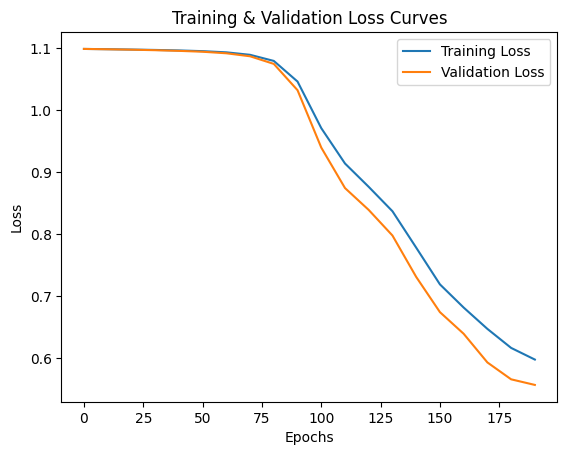

In [46]:
# Plot some of the results
plt.plot(epoch_count, train_loss_values, label="Training Loss")
plt.plot(epoch_count, valid_loss_values, label="Validation Loss")
plt.title("Training & Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Save Model

In [18]:
# Create a directory for models
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path
MODEL_NAME = "vector_centralized_pytorch_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)